# Part I. RUL prediction using Transformer model (Centralize model)

# Preparation

In [79]:
# When run code on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
print(f'IN_COLAB: {IN_COLAB}')

IN_COLAB: False


In [80]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

/home/os/anaconda3/envs/.venv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=607248) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [81]:
# Off log duplicate messages
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

# Off warning messages
import warnings
warnings.filterwarnings('ignore')

if not IN_COLAB:
    try:
        import pyinspect as pi
    except:
        pass

In [82]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from datasets.utils.logging import disable_progress_bar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

import shap

In [83]:
# Check GPU if available else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu124


# Building Transformer model

In [162]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

# Building Dataloader

In [85]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):

        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Define parameters for training

In [86]:
# Transformer parameters
input_dim = 21
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 1e-3
verbose=False

# Dataloader parameters
sequence_length = 30

# Training parameters
batch_size = 128
epochs = 50

# Define training/test functions

In [87]:
def train_model(model, client_loader_train, client_loader_validation: None, epochs: int, learning_rate: int, verbose=False):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(client_loader_train)}, Validation Loss: {val_loss/len(client_loader_validation)}")

In [88]:
def test_model(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in client_loader_validation:
            samples, targets = batch
            samples, targets = samples.to(DEVICE), targets.to(DEVICE)
            predictions = model(samples)
            val_loss += criterion(predictions, targets).item()
    return val_loss/len(client_loader_validation)

# Define prediction functions

### Prediction on a batch

In [89]:
def predict_on_batch(model, batch_loader, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    samples, targets = batch_loader
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    loss = 0
    with torch.no_grad():
        predictions = model(samples)
    loss = criterion(predictions, targets)

    if return_actual_rul:
        samples = samples.cpu()
        targets = targets.cpu()

        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        predictions = predictions.cpu()
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return loss, actual_predictions, actual_targets

    return loss

### Prediction on a sample

# File paths

In [90]:
if not IN_COLAB:
    train_1_path = "../data/train_FD001.txt"
    test_1_path = "../data/test_FD001.txt"
    rul_1_path = "../data/RUL_FD001.txt"

    train_2_path = "../data/train_FD002.txt"
    test_2_path = "../data/test_FD002.txt"
    rul_2_path = "../data/RUL_FD002.txt"

    train_3_path = "../data/train_FD003.txt"
    test_3_path = "../data/test_FD003.txt"
    rul_3_path = "../data/RUL_FD003.txt"

    train_4_path = "../data/train_FD004.txt"
    test_4_path = "../data/test_FD004.txt"
    rul_4_path = "../data/RUL_FD004.txt"
    
elif IN_COLAB:
    train_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
    test_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD001.txt"
    rul_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD001.txt"

    train_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
    test_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD002.txt"
    rul_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD002.txt"

    train_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
    test_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD003.txt"
    rul_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD003.txt"

    train_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
    test_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD004.txt"
    rul_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD004.txt"

In [91]:
# Initialization columns
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

# Calculate RUL for FD001

### Calculate RUL for train set

In [92]:
# Load trainset
train_1 = pd.read_csv(train_1_path, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
# train_1.head()

In [93]:
# Calculate the remaining RUL for each engine
max_cycle_1 = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle_1.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

print(f"trainset shape: {train_1.shape}")

trainset shape: (20631, 27)


In [94]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Load RUL set

In [95]:
rul_1 = pd.read_csv(rul_1_path, sep=' ', header=None)
rul_1.drop(rul_1.columns[1], axis=1, inplace=True)
rul_1.columns = ['RUL']
print(f'RUL shape: {rul_1.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [96]:
rul_1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculate RUL for test

In [97]:
# Load test set
test_1 = pd.read_csv(test_1_path, sep=' ', header=None)
test_1.drop([26, 27], axis=1, inplace=True)
test_1.columns = column_names

test_1['Remaining RUL'] = ''
# test_1.head()

In [98]:
max_cycle_test_1 = test_1.groupby('ID Engine').count()

for idx in range(len(test_1)):
    test_1.loc[idx, 'Remaining RUL'] = rul_1.loc[test_1.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_1.loc[test_1.loc[idx, 'ID Engine'], 'Cycle']
test_1['Remaining RUL'] = test_1['Remaining RUL'] - test_1['Cycle']

In [99]:
test_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


# Calculate RUL for FD002

### Calculate RUL for train set

In [100]:
# Load trainset
train_2 = pd.read_csv(train_2_path, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
# train_2.head()

In [101]:
# Calculate the remaining RUL for each engine
max_cycle_2 = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle_2.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

print(f"trainset shape: {train_2.shape}")

trainset shape: (53759, 27)


In [102]:
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


### Load RUL set

In [103]:
rul_2 = pd.read_csv(rul_2_path, sep=' ', header=None)
rul_2.drop(rul_2.columns[1], axis=1, inplace=True)
rul_2.columns = ['RUL']
print(f'RUL shape: {rul_2.shape}')

RUL shape: (259, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [104]:
rul_2.head()

,RUL
0,18
1,79
2,106
3,110
4,15


### Calculate RUL for test

In [105]:
# Load test set
test_2 = pd.read_csv(test_2_path, sep=' ', header=None)
test_2.drop([26, 27], axis=1, inplace=True)
test_2.columns = column_names

test_2['Remaining RUL'] = ''
# test_2.head()

In [106]:
max_cycle_test_2 = test_2.groupby('ID Engine').count()

for idx in range(len(test_2)):
    test_2.loc[idx, 'Remaining RUL'] = rul_2.loc[test_2.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_2.loc[test_2.loc[idx, 'ID Engine'], 'Cycle']
test_2['Remaining RUL'] = test_2['Remaining RUL'] - test_2['Cycle']

In [107]:
test_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


# Calculate RUL for FD003

### Calculate RUL for train set

In [108]:
# Load trainset
train_3 = pd.read_csv(train_3_path, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
# train_3.head()

In [109]:
# Calculate the remaining RUL for each engine
max_cycle_3 = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle_3.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

print(f"trainset shape: {train_3.shape}")

trainset shape: (24720, 27)


In [110]:
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Load RUL set

In [111]:
rul_3 = pd.read_csv(rul_3_path, sep=' ', header=None)
rul_3.drop(rul_3.columns[1], axis=1, inplace=True)
rul_3.columns = ['RUL']
print(f'RUL shape: {rul_3.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [112]:
rul_3.head()

,RUL
0,44
1,51
2,27
3,120
4,101


### Calculate RUL for test

In [113]:
# Load test set
test_3 = pd.read_csv(test_3_path, sep=' ', header=None)
test_3.drop([26, 27], axis=1, inplace=True)
test_3.columns = column_names

test_3['Remaining RUL'] = ''
# test_3.head()

In [114]:
max_cycle_test_3 = test_3.groupby('ID Engine').count()

for idx in range(len(test_3)):
    test_3.loc[idx, 'Remaining RUL'] = rul_3.loc[test_3.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_3.loc[test_3.loc[idx, 'ID Engine'], 'Cycle']
test_3['Remaining RUL'] = test_3['Remaining RUL'] - test_3['Cycle']

In [115]:
test_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


# Calculate RUL for FD004

### Calculate RUL for train set

In [116]:
# Load trainset
train_4 = pd.read_csv(train_4_path, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
# train_4.head()

In [117]:
# Calculate the remaining RUL for each engine
max_cycle_4 = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle_4.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

print(f"trainset shape: {train_4.shape}")

trainset shape: (61249, 27)


In [118]:
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


### Load RUL set

In [119]:
rul_4 = pd.read_csv(rul_4_path, sep=' ', header=None)
rul_4.drop(rul_4.columns[1], axis=1, inplace=True)
rul_4.columns = ['RUL']
print(f'RUL shape: {rul_4.shape}')

RUL shape: (248, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [120]:
rul_4.head()

,RUL
0,22
1,39
2,107
3,75
4,149


### Calculate RUL for test

In [121]:
# Load test set
test_4 = pd.read_csv(test_4_path, sep=' ', header=None)
test_4.drop([26, 27], axis=1, inplace=True)
test_4.columns = column_names

test_4['Remaining RUL'] = ''
# test_4.head()

In [122]:
max_cycle_test_4 = test_4.groupby('ID Engine').count()

for idx in range(len(test_4)):
    test_4.loc[idx, 'Remaining RUL'] = rul_4.loc[test_4.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_4.loc[test_4.loc[idx, 'ID Engine'], 'Cycle']
test_4['Remaining RUL'] = test_4['Remaining RUL'] - test_4['Cycle']

In [123]:
test_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


# Plot number of sample for each dataset

In [124]:
len(train_1)

20631

In [125]:
len(train_2)

53759

In [126]:
len(train_3)

24720

In [127]:
len(train_4)

61249

In [128]:
total = len(train_1) + len(train_2) + len(train_3) + len(train_4)
total

160359

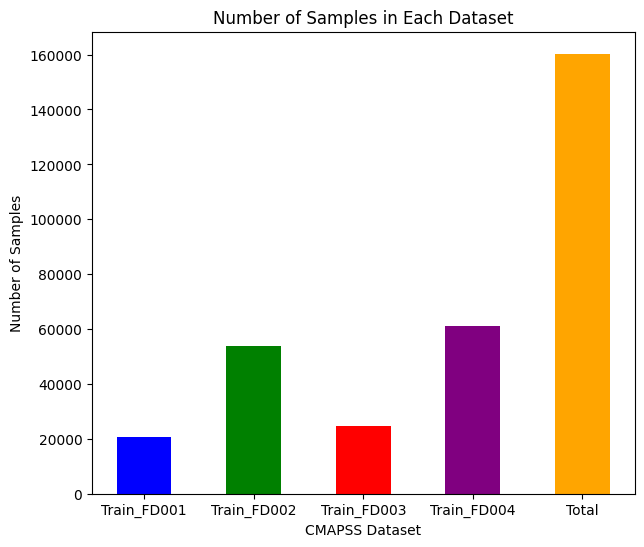

In [129]:
sample_counts = [len(train_1), len(train_2), len(train_3), len(train_4), total]
labels = ['Train_FD001', 'Train_FD002', 'Train_FD003', 'Train_FD004', 'Total']

plt.figure(figsize=(7, 6))
plt.bar(labels, sample_counts, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
plt.xlabel('CMAPSS Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')
plt.show()

# Concatenate for train_FD001,2,3,4

In [130]:
print(f'train_1 shape: {train_1.shape}')
print(f'test_1 shape: {test_1.shape}')
print(f'rul_1 shape: {rul_1.shape}')
print(f'max_cycle_1 shape: {max_cycle_1.shape}')

train_1 shape: (20631, 27)
test_1 shape: (13096, 27)
rul_1 shape: (100, 1)
max_cycle_1 shape: (100, 26)


In [131]:
print(f'train_2 shape: {train_2.shape}')
print(f'test_2 shape: {test_2.shape}')
print(f'rul_2 shape: {rul_2.shape}')
print(f'max_cycle_2 shape: {max_cycle_2.shape}')

train_2 shape: (53759, 27)
test_2 shape: (33991, 27)
rul_2 shape: (259, 1)
max_cycle_2 shape: (260, 26)


In [132]:
print(f'train_3 shape: {train_3.shape}')
print(f'test_3 shape: {test_3.shape}')
print(f'rul_3 shape: {rul_3.shape}')
print(f'max_cycle_3 shape: {max_cycle_3.shape}')

train_3 shape: (24720, 27)
test_3 shape: (16596, 27)
rul_3 shape: (100, 1)
max_cycle_3 shape: (100, 26)


In [133]:
print(f'train_4 shape: {train_4.shape}')
print(f'test_4 shape: {test_4.shape}')
print(f'rul_4 shape: {rul_4.shape}')
print(f'max_cycle_4 shape: {max_cycle_4.shape}')

train_4 shape: (61249, 27)
test_4 shape: (41214, 27)
rul_4 shape: (248, 1)
max_cycle_4 shape: (249, 26)


In [134]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [135]:
num = len(train_1)
for idx in range(len(train_2)):
    train_2.loc[idx, 'ID Engine'] += num
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,20632,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,20632,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,20632,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,20632,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,20632,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [136]:
num += len(train_2)
for idx in range(len(train_3)):
    train_3.loc[idx, 'ID Engine'] += num
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,74391,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,74391,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,74391,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,74391,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,74391,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [137]:
num += len(train_3)
for idx in range(len(train_4)):
    train_4.loc[idx, 'ID Engine'] += num
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,99111,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,99111,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,99111,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,99111,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,99111,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [138]:
train = pd.concat([train_1, train_2, train_3, train_4], ignore_index=True)
print(f'Train shape: {train.shape}')
train.head()

Train shape: (160359, 27)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Standard data (for train and test set)

In [139]:
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [140]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.993194,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,0.352399
1,1,2,0.0019,-0.0003,100.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.993332,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,0.350554
2,1,3,-0.0043,0.0003,100.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.993222,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,0.348708
3,1,4,0.0007,0.0000,100.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.993359,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,0.346863
4,1,5,-0.0019,-0.0002,100.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.993249,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,0.345018


In [141]:
# test.head()

# Training with sequence_length = 5

### Load data into DataLoader

In [142]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=5)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

### Training centralize model

In [163]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [164]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/50, Train Loss: 0.031443647094789494, Validation Loss: 0.023371625872638063
Epoch 2/50, Train Loss: 0.020523246007068507, Validation Loss: 0.011454424705838987
Epoch 3/50, Train Loss: 0.012327979595357846, Validation Loss: 0.01126443677457419
Epoch 4/50, Train Loss: 0.011509524037598202, Validation Loss: 0.010694132399507741
Epoch 5/50, Train Loss: 0.011408124917995203, Validation Loss: 0.011532498225720547
Epoch 6/50, Train Loss: 0.011092743938930597, Validation Loss: 0.01019787255614272
Epoch 7/50, Train Loss: 0.011050343871835223, Validation Loss: 0.010250800513560593
Epoch 8/50, Train Loss: 0.010971601958372417, Validation Loss: 0.010243028835940216
Epoch 9/50, Train Loss: 0.010834161052716717, Validation Loss: 0.010512680173493348
Epoch 10/50, Train Loss: 0.010729908223646849, Validation Loss: 0.010282481306040215
Epoch 11/50, Train Loss: 0.01068664480681498, Validation Loss: 0.010568701371791875
Epoch 12/50, Train Loss: 0.010652192057994416, Validation Loss: 0.01047968421

### Predict on batch

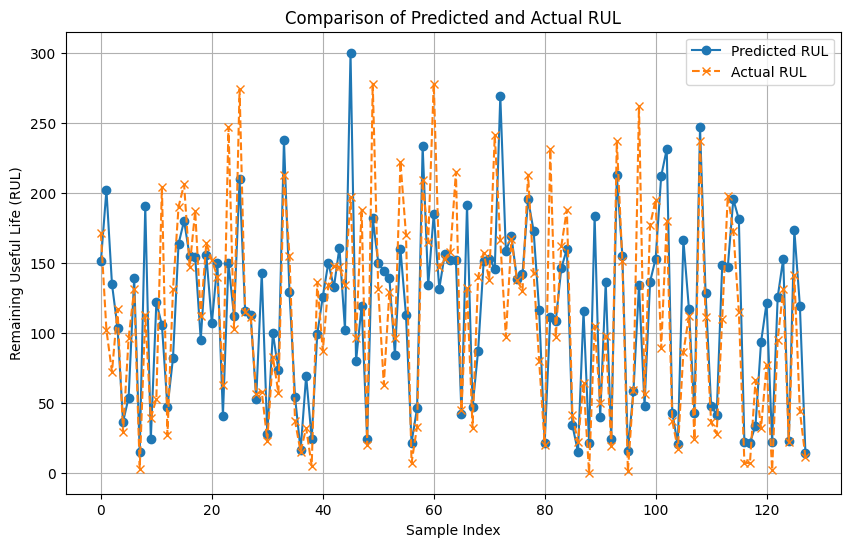

Loss on random batch: 0.006894357036799192


In [165]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Part II. Explainable Artificial Intelligence for RUL forecasting using Transformer model

### XAI summary plot for 5 random samples

Sample Data Shape: torch.Size([10, 5, 21])
SHAP Values Shape: (10, 105)
Feature Names Length: 105


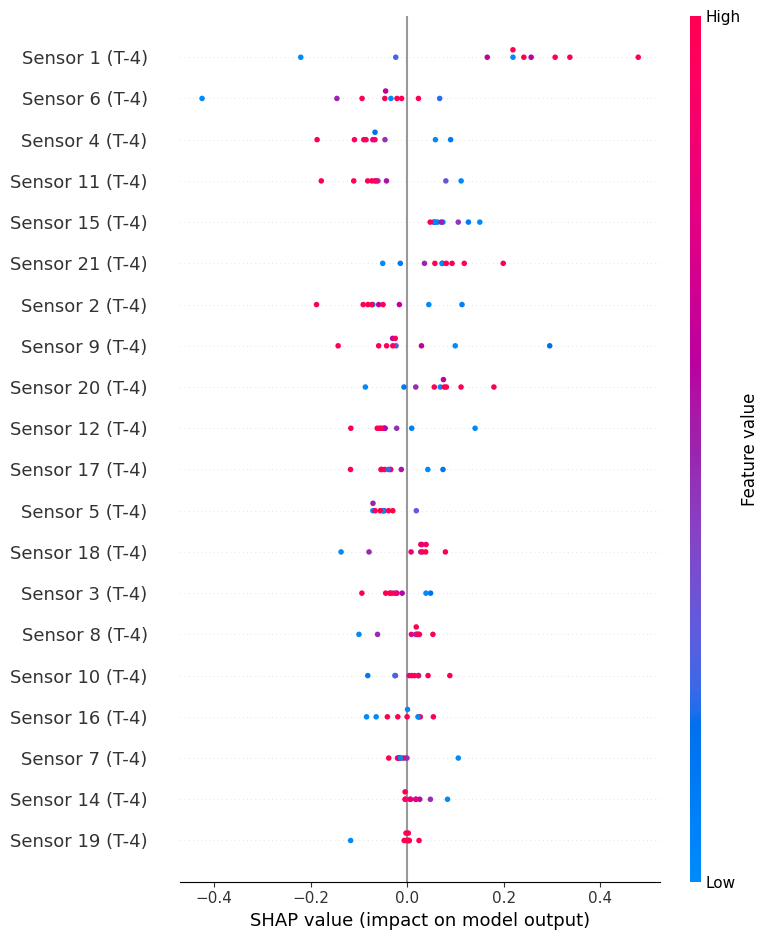

In [174]:
import shap
import torch
import numpy as np

# Chuyển mô hình về chế độ eval
centralize_transformer_model.cpu()
centralize_transformer_model.eval()

# 🔹 Bọc mô hình để đảm bảo đầu ra có đúng shape
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # Output có shape (batch_size,)
        return output.unsqueeze(-1)  # Chuyển về (batch_size, 1) cho SHAP

wrapped_model = ModelWrapper(centralize_transformer_model)

# 🔹 Lấy background dataset từ validation_loader
num_samples = 50  # Chọn 50 mẫu làm dữ liệu nền
background_data, _ = next(iter(validation_loader))  
background_data = background_data[:num_samples]  # Chọn num_samples mẫu
background_data = background_data.to(torch.float32)  # Đảm bảo đúng kiểu dữ liệu

# Sử dụng SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, background_data)

# 🔹 Chọn một số mẫu từ validation để giải thích
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:10].to(torch.float32)  # Chỉ lấy 10 mẫu

# 🔹 Tính giá trị SHAP
shap_values = explainer.shap_values(sample_data)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 🔹 Đảm bảo SHAP values có đúng shape (batch_size, num_features)
shap_values = shap_values.reshape(sample_data.shape[0], -1)
sample_data_reshaped = sample_data.numpy().reshape(sample_data.shape[0], -1)

# 🔹 Định nghĩa feature_names: 21 cảm biến, 5 timestep
num_sensors = 21
num_timesteps = 5
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# Kiểm tra lại kích thước
print("Sample Data Shape:", sample_data.shape)  
print("SHAP Values Shape:", shap_values.shape)  
print("Feature Names Length:", len(feature_names))  # Phải là 105

# 🔹 Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, sample_data_reshaped, feature_names=feature_names)


Sample Data Shape: torch.Size([10, 5, 21])
SHAP Values Shape: (10, 105)
Feature Names Length: 105


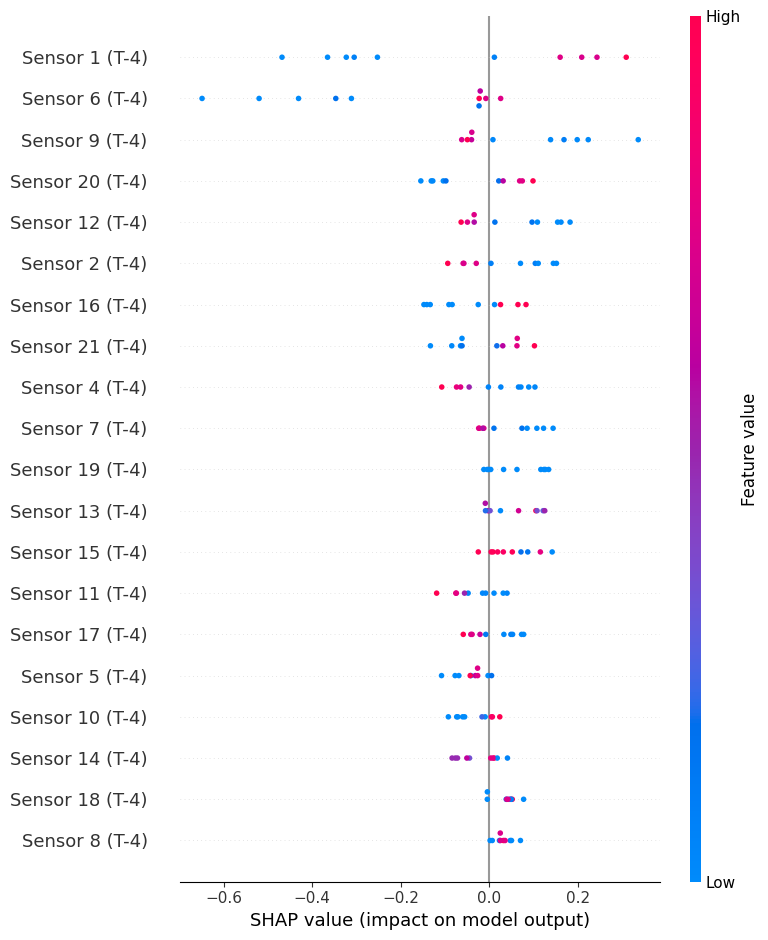

In [175]:
import shap
import torch
import numpy as np

# Chuyển mô hình về chế độ eval
centralize_transformer_model.cpu()
centralize_transformer_model.eval()

# 🔹 Bọc mô hình để đảm bảo đầu ra có đúng shape
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # Output có shape (batch_size,)
        return output.unsqueeze(-1)  # Chuyển về (batch_size, 1) cho SHAP

wrapped_model = ModelWrapper(centralize_transformer_model)

# 🔹 Lấy background dataset từ validation_loader
num_samples = 50  # Chọn 50 mẫu làm dữ liệu nền
background_data, _ = next(iter(validation_loader))  
background_data = background_data[:num_samples]  # Chọn num_samples mẫu
background_data = background_data.to(torch.float32)  # Đảm bảo đúng kiểu dữ liệu

# Sử dụng SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, background_data)

# 🔹 Chọn một số mẫu từ validation để giải thích
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:10].to(torch.float32)  # Chỉ lấy 10 mẫu

# 🔹 Tính giá trị SHAP
shap_values = explainer.shap_values(sample_data)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 🔹 Đảm bảo SHAP values có đúng shape (batch_size, num_features)
shap_values = shap_values.reshape(sample_data.shape[0], -1)
sample_data_reshaped = sample_data.numpy().reshape(sample_data.shape[0], -1)

# 🔹 Định nghĩa feature_names: 21 cảm biến, 5 timestep
num_sensors = 21
num_timesteps = 5
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# Kiểm tra lại kích thước
print("Sample Data Shape:", sample_data.shape)  
print("SHAP Values Shape:", shap_values.shape)  
print("Feature Names Length:", len(feature_names))  # Phải là 105

# 🔹 Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, sample_data_reshaped, feature_names=feature_names)


Sample Data Shape: torch.Size([10, 5, 21])
SHAP Values Shape: (10, 105)
Feature Names Length: 105


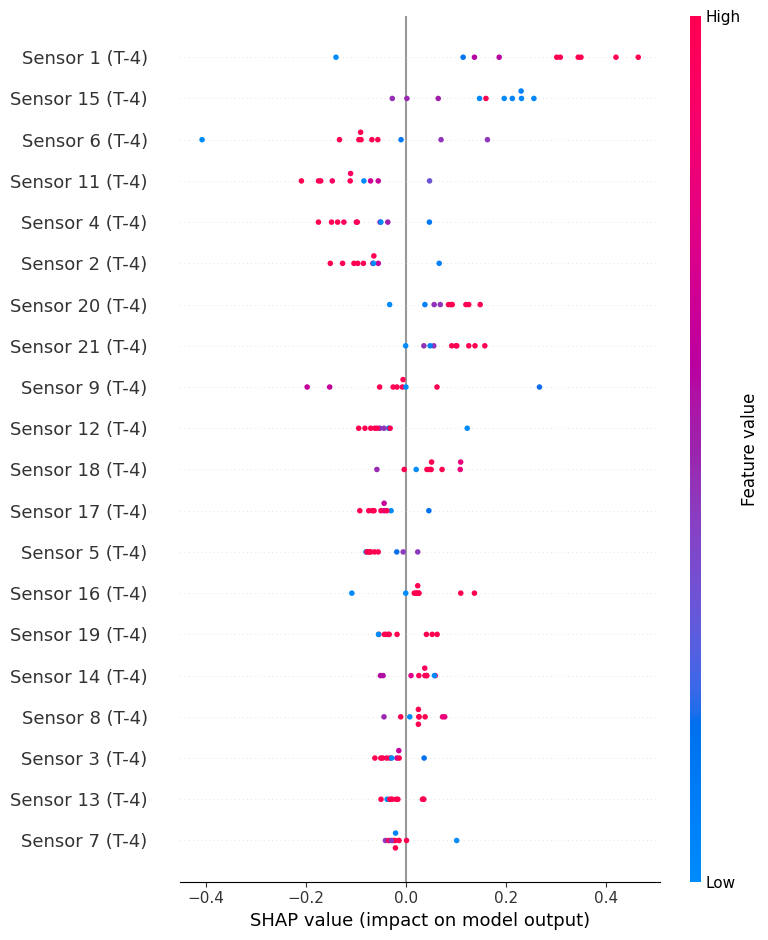

In [176]:
import shap
import torch
import numpy as np

# Chuyển mô hình về chế độ eval
centralize_transformer_model.cpu()
centralize_transformer_model.eval()

# 🔹 Bọc mô hình để đảm bảo đầu ra có đúng shape
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # Output có shape (batch_size,)
        return output.unsqueeze(-1)  # Chuyển về (batch_size, 1) cho SHAP

wrapped_model = ModelWrapper(centralize_transformer_model)

# 🔹 Lấy background dataset từ validation_loader
num_samples = 50  # Chọn 50 mẫu làm dữ liệu nền
background_data, _ = next(iter(validation_loader))  
background_data = background_data[:num_samples]  # Chọn num_samples mẫu
background_data = background_data.to(torch.float32)  # Đảm bảo đúng kiểu dữ liệu

# Sử dụng SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, background_data)

# 🔹 Chọn một số mẫu từ validation để giải thích
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:10].to(torch.float32)  # Chỉ lấy 10 mẫu

# 🔹 Tính giá trị SHAP
shap_values = explainer.shap_values(sample_data)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 🔹 Đảm bảo SHAP values có đúng shape (batch_size, num_features)
shap_values = shap_values.reshape(sample_data.shape[0], -1)
sample_data_reshaped = sample_data.numpy().reshape(sample_data.shape[0], -1)

# 🔹 Định nghĩa feature_names: 21 cảm biến, 5 timestep
num_sensors = 21
num_timesteps = 5
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# Kiểm tra lại kích thước
print("Sample Data Shape:", sample_data.shape)  
print("SHAP Values Shape:", shap_values.shape)  
print("Feature Names Length:", len(feature_names))  # Phải là 105

# 🔹 Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, sample_data_reshaped, feature_names=feature_names)


Sample Data Shape: torch.Size([10, 5, 21])
SHAP Values Shape: (10, 105)
Feature Names Length: 105


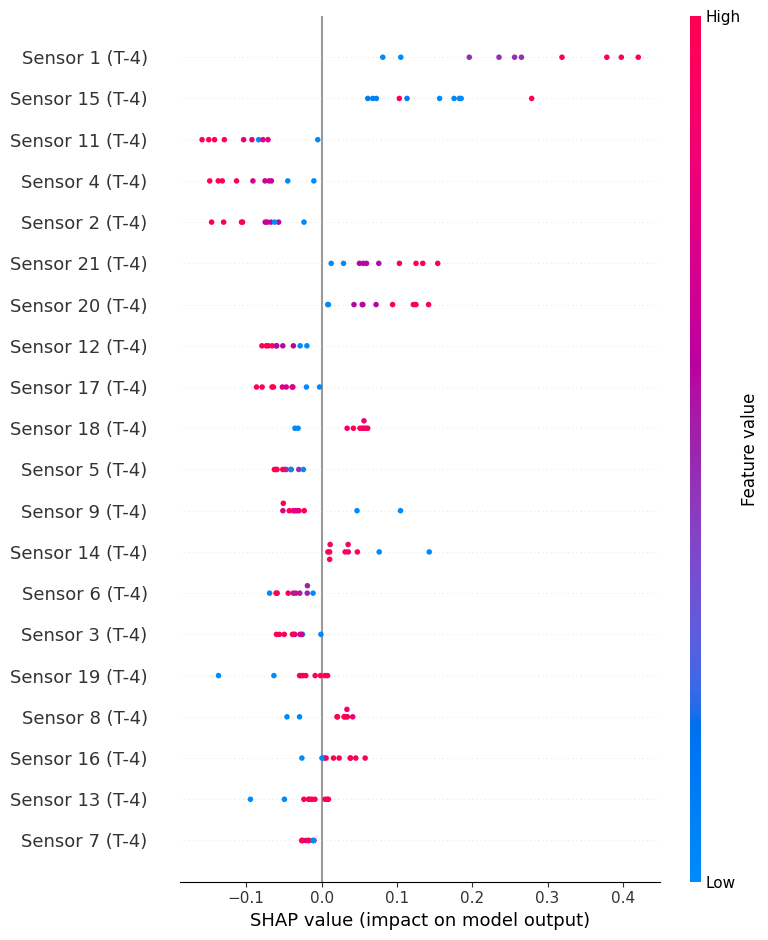

In [177]:
import shap
import torch
import numpy as np

# Chuyển mô hình về chế độ eval
centralize_transformer_model.cpu()
centralize_transformer_model.eval()

# 🔹 Bọc mô hình để đảm bảo đầu ra có đúng shape
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # Output có shape (batch_size,)
        return output.unsqueeze(-1)  # Chuyển về (batch_size, 1) cho SHAP

wrapped_model = ModelWrapper(centralize_transformer_model)

# 🔹 Lấy background dataset từ validation_loader
num_samples = 50  # Chọn 50 mẫu làm dữ liệu nền
background_data, _ = next(iter(validation_loader))  
background_data = background_data[:num_samples]  # Chọn num_samples mẫu
background_data = background_data.to(torch.float32)  # Đảm bảo đúng kiểu dữ liệu

# Sử dụng SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, background_data)

# 🔹 Chọn một số mẫu từ validation để giải thích
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:10].to(torch.float32)  # Chỉ lấy 10 mẫu

# 🔹 Tính giá trị SHAP
shap_values = explainer.shap_values(sample_data)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 🔹 Đảm bảo SHAP values có đúng shape (batch_size, num_features)
shap_values = shap_values.reshape(sample_data.shape[0], -1)
sample_data_reshaped = sample_data.numpy().reshape(sample_data.shape[0], -1)

# 🔹 Định nghĩa feature_names: 21 cảm biến, 5 timestep
num_sensors = 21
num_timesteps = 5
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# Kiểm tra lại kích thước
print("Sample Data Shape:", sample_data.shape)  
print("SHAP Values Shape:", shap_values.shape)  
print("Feature Names Length:", len(feature_names))  # Phải là 105

# 🔹 Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, sample_data_reshaped, feature_names=feature_names)


Sample Data Shape: torch.Size([10, 5, 21])
SHAP Values Shape: (10, 105)
Feature Names Length: 105


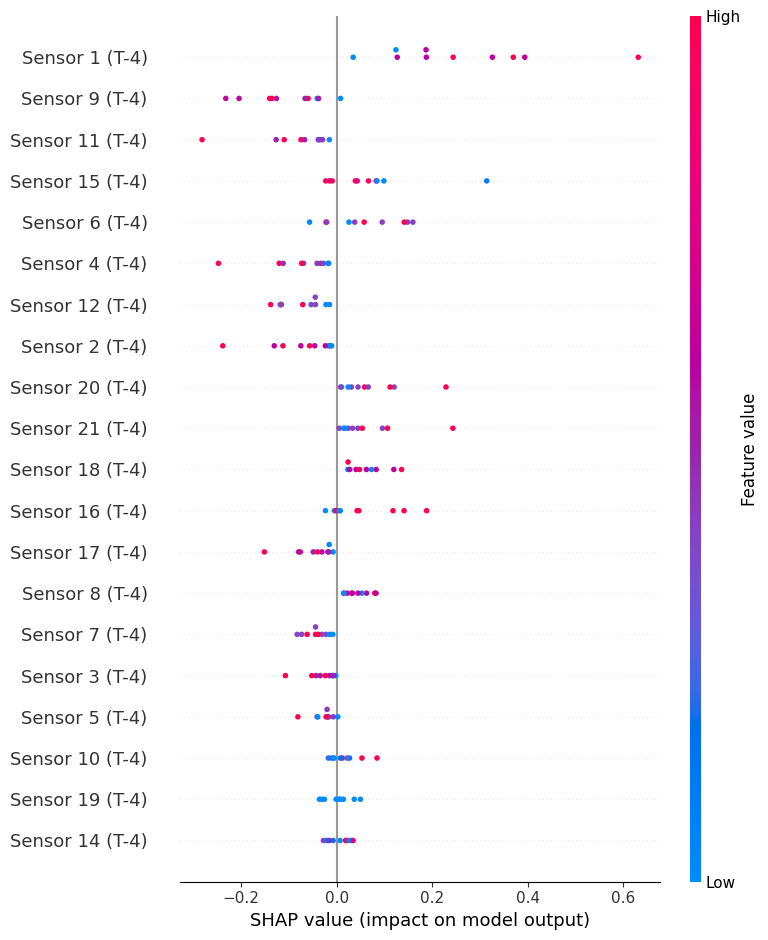

In [178]:
import shap
import torch
import numpy as np

# Chuyển mô hình về chế độ eval
centralize_transformer_model.cpu()
centralize_transformer_model.eval()

# 🔹 Bọc mô hình để đảm bảo đầu ra có đúng shape
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)  # Output có shape (batch_size,)
        return output.unsqueeze(-1)  # Chuyển về (batch_size, 1) cho SHAP

wrapped_model = ModelWrapper(centralize_transformer_model)

# 🔹 Lấy background dataset từ validation_loader
num_samples = 50  # Chọn 50 mẫu làm dữ liệu nền
background_data, _ = next(iter(validation_loader))  
background_data = background_data[:num_samples]  # Chọn num_samples mẫu
background_data = background_data.to(torch.float32)  # Đảm bảo đúng kiểu dữ liệu

# Sử dụng SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, background_data)

# 🔹 Chọn một số mẫu từ validation để giải thích
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:10].to(torch.float32)  # Chỉ lấy 10 mẫu

# 🔹 Tính giá trị SHAP
shap_values = explainer.shap_values(sample_data)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 🔹 Đảm bảo SHAP values có đúng shape (batch_size, num_features)
shap_values = shap_values.reshape(sample_data.shape[0], -1)
sample_data_reshaped = sample_data.numpy().reshape(sample_data.shape[0], -1)

# 🔹 Định nghĩa feature_names: 21 cảm biến, 5 timestep
num_sensors = 21
num_timesteps = 5
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# Kiểm tra lại kích thước
print("Sample Data Shape:", sample_data.shape)  
print("SHAP Values Shape:", shap_values.shape)  
print("Feature Names Length:", len(feature_names))  # Phải là 105

# 🔹 Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, sample_data_reshaped, feature_names=feature_names)


### XAI waterfall plot for 5 random samples

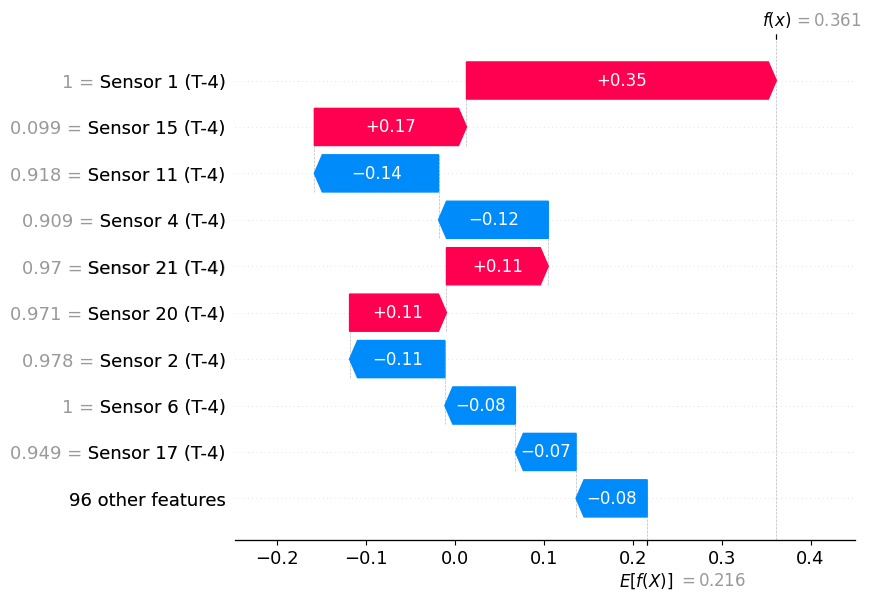

In [182]:
import shap
import torch

# 🔹 Tính expected_value bằng cách chạy mô hình trên dữ liệu nền
background_preds = centralize_transformer_model(background_data).detach().cpu().numpy()
expected_value = background_preds.mean()  # Giá trị mong đợi của mô hình

# 🔹 Chọn một mẫu từ tập validation
sample_idx = 0  # Chọn mẫu đầu tiên để hiển thị
single_sample = sample_data[sample_idx].unsqueeze(0)  # Định dạng lại thành (1, feature_dim)

# 🔹 Tính SHAP values cho mẫu này
shap_values_single = explainer.shap_values(single_sample)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# 🔹 Chuyển về numpy để hiển thị
shap_values_single = shap_values_single.reshape(-1)  # Chuyển về dạng vector 1D
single_sample_reshaped = single_sample.numpy().reshape(-1)  # Chuyển input về dạng vector 1D

# 🔹 Lấy tên các feature (21 cảm biến, 5 timestep)
num_timesteps = 5
num_sensors = 21
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# 🔹 Vẽ biểu đồ Waterfall Plot
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                     base_values=expected_value,  # Giá trị mong đợi
                                     data=single_sample_reshaped, 
                                     feature_names=feature_names))


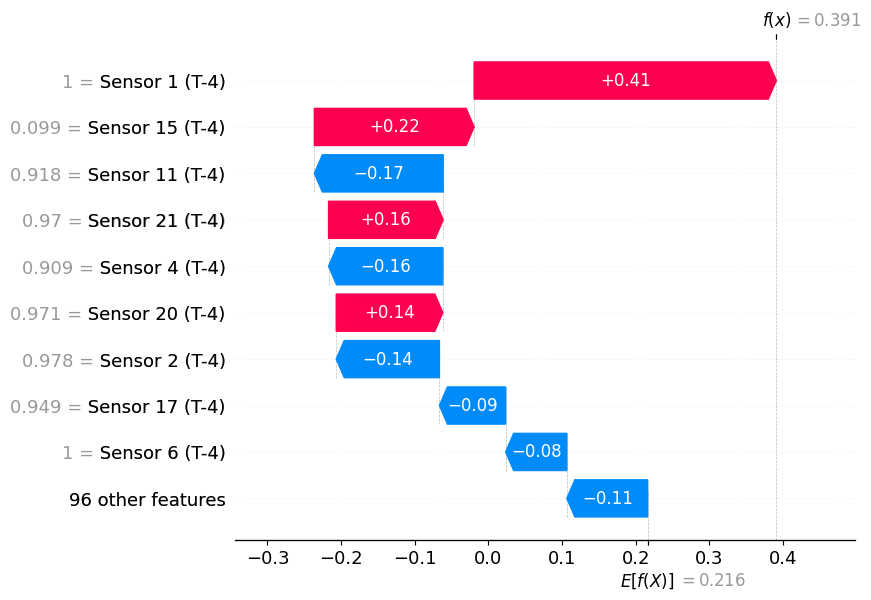

In [183]:
import shap
import torch

# 🔹 Tính expected_value bằng cách chạy mô hình trên dữ liệu nền
background_preds = centralize_transformer_model(background_data).detach().cpu().numpy()
expected_value = background_preds.mean()  # Giá trị mong đợi của mô hình

# 🔹 Chọn một mẫu từ tập validation
sample_idx = 0  # Chọn mẫu đầu tiên để hiển thị
single_sample = sample_data[sample_idx].unsqueeze(0)  # Định dạng lại thành (1, feature_dim)

# 🔹 Tính SHAP values cho mẫu này
shap_values_single = explainer.shap_values(single_sample)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# 🔹 Chuyển về numpy để hiển thị
shap_values_single = shap_values_single.reshape(-1)  # Chuyển về dạng vector 1D
single_sample_reshaped = single_sample.numpy().reshape(-1)  # Chuyển input về dạng vector 1D

# 🔹 Lấy tên các feature (21 cảm biến, 5 timestep)
num_timesteps = 5
num_sensors = 21
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# 🔹 Vẽ biểu đồ Waterfall Plot
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                     base_values=expected_value,  # Giá trị mong đợi
                                     data=single_sample_reshaped, 
                                     feature_names=feature_names))


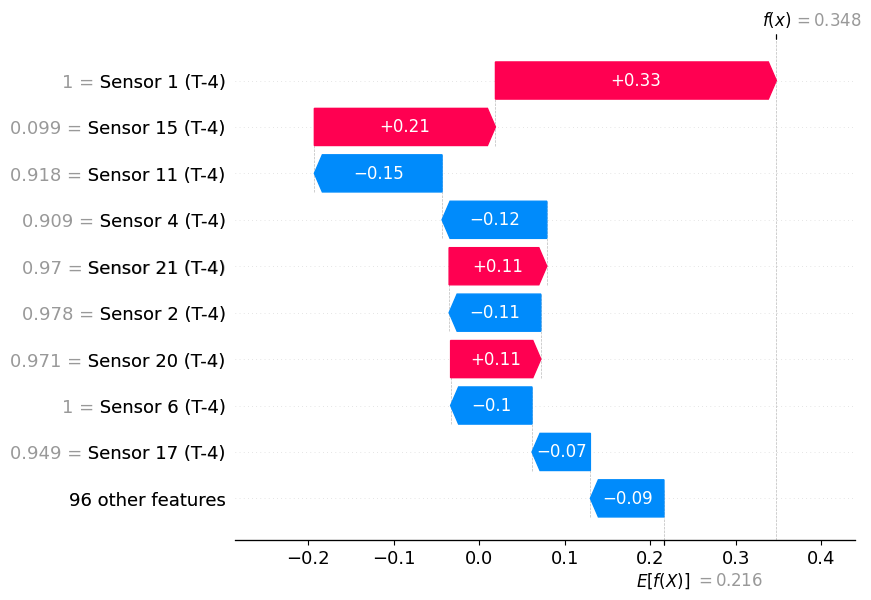

In [184]:
import shap
import torch

# 🔹 Tính expected_value bằng cách chạy mô hình trên dữ liệu nền
background_preds = centralize_transformer_model(background_data).detach().cpu().numpy()
expected_value = background_preds.mean()  # Giá trị mong đợi của mô hình

# 🔹 Chọn một mẫu từ tập validation
sample_idx = 0  # Chọn mẫu đầu tiên để hiển thị
single_sample = sample_data[sample_idx].unsqueeze(0)  # Định dạng lại thành (1, feature_dim)

# 🔹 Tính SHAP values cho mẫu này
shap_values_single = explainer.shap_values(single_sample)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# 🔹 Chuyển về numpy để hiển thị
shap_values_single = shap_values_single.reshape(-1)  # Chuyển về dạng vector 1D
single_sample_reshaped = single_sample.numpy().reshape(-1)  # Chuyển input về dạng vector 1D

# 🔹 Lấy tên các feature (21 cảm biến, 5 timestep)
num_timesteps = 5
num_sensors = 21
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# 🔹 Vẽ biểu đồ Waterfall Plot
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                     base_values=expected_value,  # Giá trị mong đợi
                                     data=single_sample_reshaped, 
                                     feature_names=feature_names))


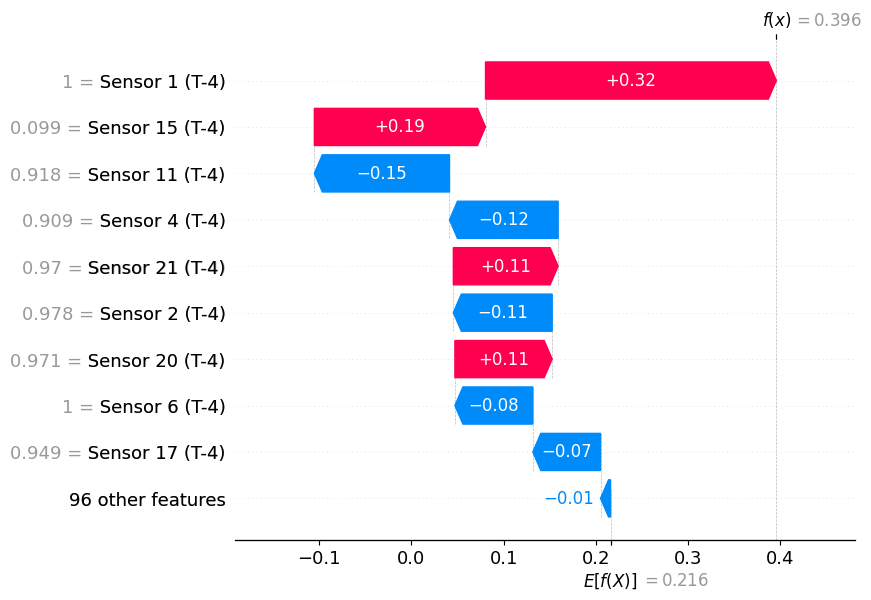

In [185]:
import shap
import torch

# 🔹 Tính expected_value bằng cách chạy mô hình trên dữ liệu nền
background_preds = centralize_transformer_model(background_data).detach().cpu().numpy()
expected_value = background_preds.mean()  # Giá trị mong đợi của mô hình

# 🔹 Chọn một mẫu từ tập validation
sample_idx = 0  # Chọn mẫu đầu tiên để hiển thị
single_sample = sample_data[sample_idx].unsqueeze(0)  # Định dạng lại thành (1, feature_dim)

# 🔹 Tính SHAP values cho mẫu này
shap_values_single = explainer.shap_values(single_sample)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# 🔹 Chuyển về numpy để hiển thị
shap_values_single = shap_values_single.reshape(-1)  # Chuyển về dạng vector 1D
single_sample_reshaped = single_sample.numpy().reshape(-1)  # Chuyển input về dạng vector 1D

# 🔹 Lấy tên các feature (21 cảm biến, 5 timestep)
num_timesteps = 5
num_sensors = 21
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# 🔹 Vẽ biểu đồ Waterfall Plot
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                     base_values=expected_value,  # Giá trị mong đợi
                                     data=single_sample_reshaped, 
                                     feature_names=feature_names))


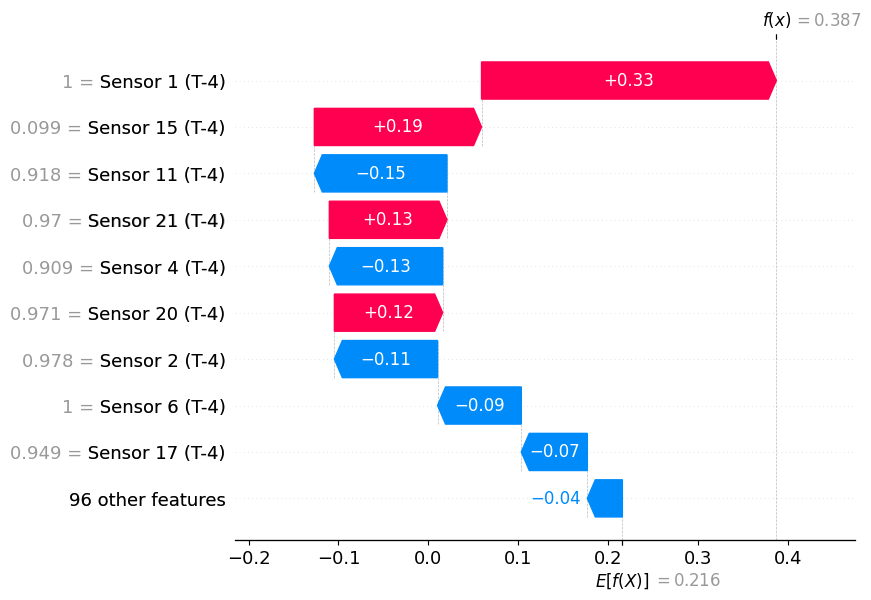

In [186]:
import shap
import torch

# 🔹 Tính expected_value bằng cách chạy mô hình trên dữ liệu nền
background_preds = centralize_transformer_model(background_data).detach().cpu().numpy()
expected_value = background_preds.mean()  # Giá trị mong đợi của mô hình

# 🔹 Chọn một mẫu từ tập validation
sample_idx = 0  # Chọn mẫu đầu tiên để hiển thị
single_sample = sample_data[sample_idx].unsqueeze(0)  # Định dạng lại thành (1, feature_dim)

# 🔹 Tính SHAP values cho mẫu này
shap_values_single = explainer.shap_values(single_sample)

# Kiểm tra nếu SHAP trả về danh sách, lấy phần tử đầu tiên
if isinstance(shap_values_single, list):
    shap_values_single = shap_values_single[0]

# 🔹 Chuyển về numpy để hiển thị
shap_values_single = shap_values_single.reshape(-1)  # Chuyển về dạng vector 1D
single_sample_reshaped = single_sample.numpy().reshape(-1)  # Chuyển input về dạng vector 1D

# 🔹 Lấy tên các feature (21 cảm biến, 5 timestep)
num_timesteps = 5
num_sensors = 21
feature_names = [f"Sensor {i+1} (T-{timestep})" for timestep in range(num_timesteps) for i in range(num_sensors)]

# 🔹 Vẽ biểu đồ Waterfall Plot
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                     base_values=expected_value,  # Giá trị mong đợi
                                     data=single_sample_reshaped, 
                                     feature_names=feature_names))


### XAI attention map plot for 5 random samples

Số module MultiheadAttention thu được: 6


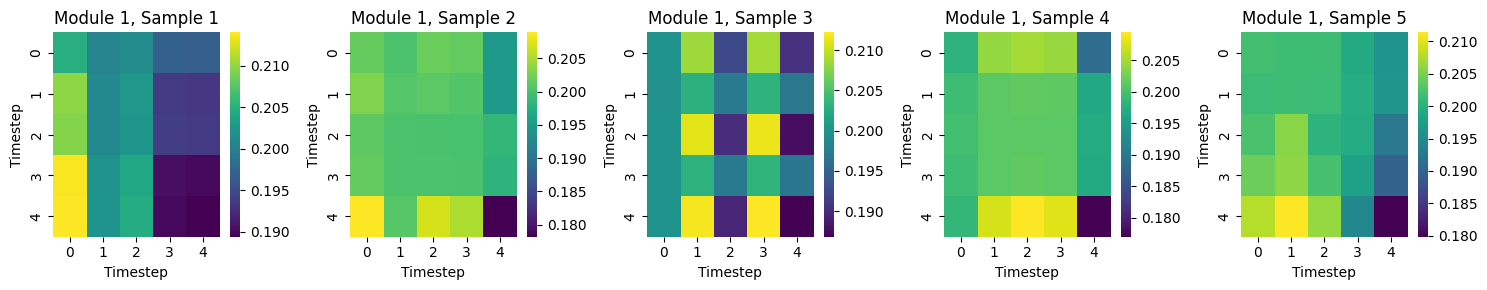

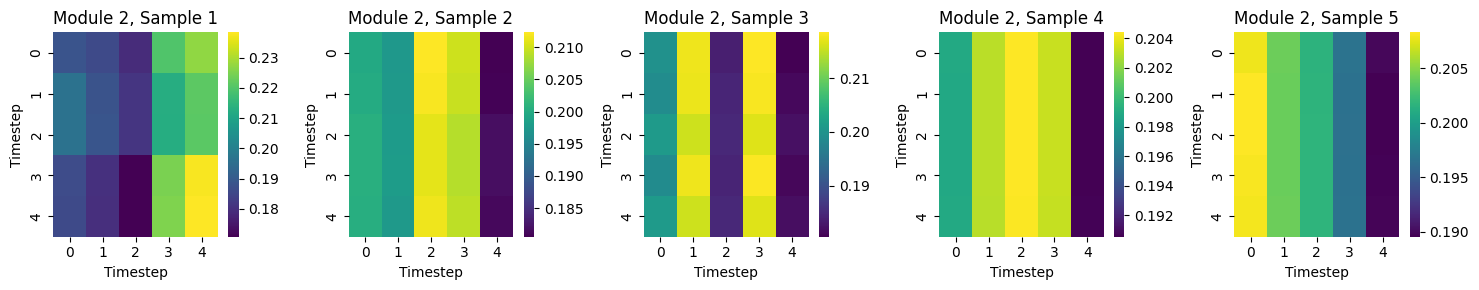

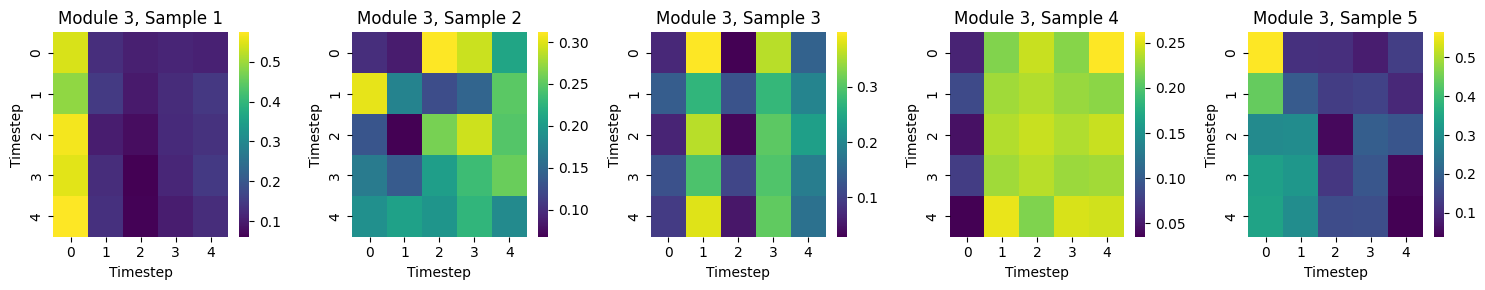

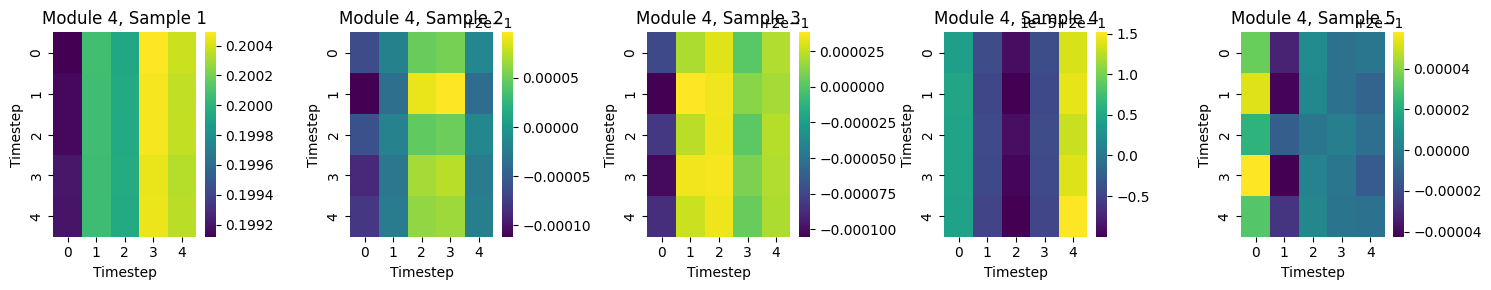

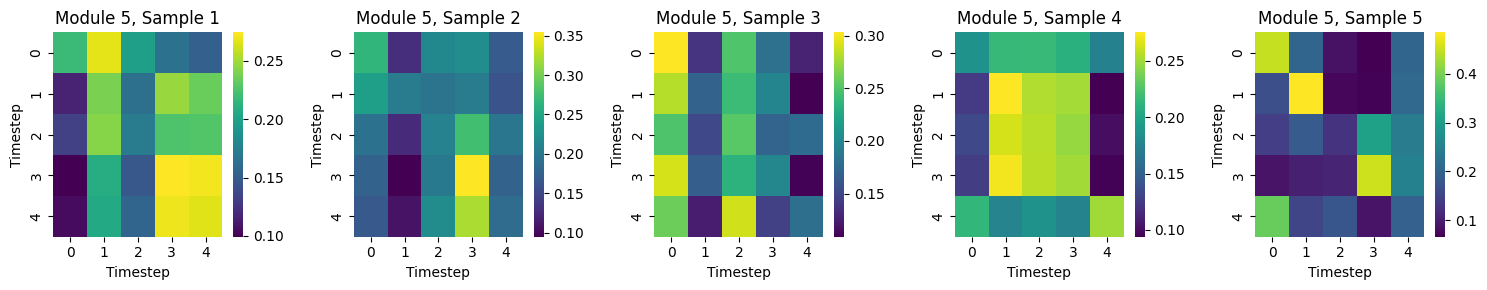

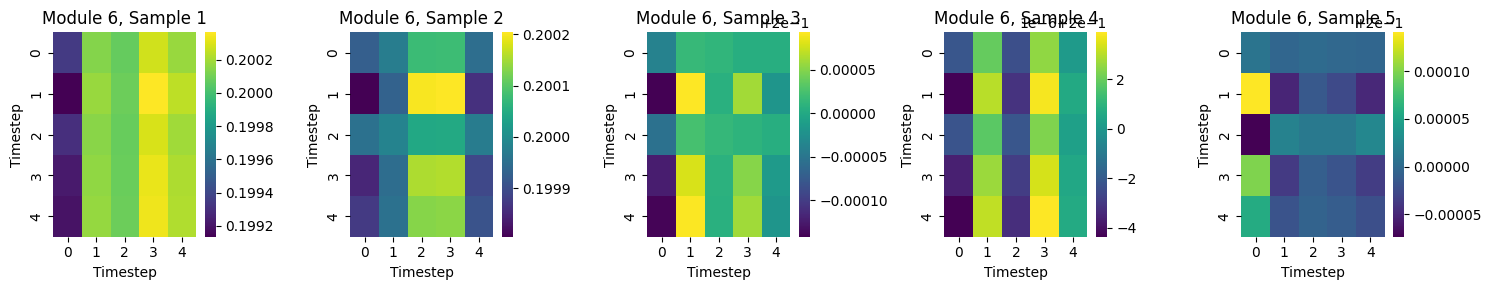

In [190]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_attention_scores(model, input_tensor):
    """
    Lấy attention maps từ mô hình Transformer bằng cách patch tạm thời các module MultiheadAttention
    để buộc luôn trả về attention weights (need_weights=True).
    """
    attention_scores = []   # Danh sách chứa attention maps (mỗi module sẽ trả về 1 tensor)
    hook_handles = []       # Danh sách các handle của hook
    original_forwards = {}  # Lưu lại các hàm forward gốc để khôi phục sau

    # Hàm helper: tạo hàm forward mới cho module MultiheadAttention để ép need_weights=True
    def create_new_forward(orig_forward):
        def new_forward(query, key, value, **kwargs):
            kwargs['need_weights'] = True
            return orig_forward(query, key, value, **kwargs)
        return new_forward

    # Tìm tất cả các module MultiheadAttention trong mô hình
    mha_modules = [m for m in model.modules() if isinstance(m, torch.nn.MultiheadAttention)]
    if not mha_modules:
        raise ValueError("Không tìm thấy module MultiheadAttention trong mô hình!")

    # Với mỗi module, lưu lại hàm forward gốc, patch lại hàm forward và đăng ký hook để thu attention weights.
    for m in mha_modules:
        original_forwards[m] = m.forward  # lưu hàm forward gốc
        m.forward = create_new_forward(m.forward)  # patch lại để buộc need_weights=True

        # Đăng ký hook: nếu output là tuple và phần thứ 2 không None thì lấy output[1]
        handle = m.register_forward_hook(
            lambda module, inp, output: attention_scores.append(
                output[1].detach().cpu() if (isinstance(output, tuple) and len(output) > 1 and output[1] is not None)
                else None
            )
        )
        hook_handles.append(handle)

    # Chạy mô hình trên input_tensor để kích hoạt các hook
    with torch.no_grad():
        _ = model(input_tensor)

    # Gỡ bỏ các hook và khôi phục lại các hàm forward gốc
    for m, orig_forward in original_forwards.items():
        m.forward = orig_forward
    for handle in hook_handles:
        handle.remove()

    # Lọc bỏ các giá trị None (nếu có)
    filtered_attention_scores = [score for score in attention_scores if score is not None]
    return filtered_attention_scores if filtered_attention_scores else None

# --- Sử dụng mô hình và lấy dữ liệu mẫu ---
centralize_transformer_model.eval()

# Giả sử validation_loader cung cấp dữ liệu có shape: [batch_size, seq_len, input_dim]
sample_data, _ = next(iter(validation_loader))
sample_data = sample_data[:5]  # Chỉ lấy 5 mẫu để vẽ Attention Map

# Lấy attention maps từ mô hình
attention_maps = get_attention_scores(centralize_transformer_model, sample_data)

# --- Vẽ Attention Maps ---
if attention_maps is not None:
    print(f"Số module MultiheadAttention thu được: {len(attention_maps)}")
    # Duyệt qua từng module (mỗi module trả về 1 tensor attention)
    for idx, attn in enumerate(attention_maps):
        if attn is None:
            continue
        # Kiểm tra số chiều của tensor attention
        if attn.ndim == 4:
            # Trường hợp: shape (batch_size, num_heads, seq_len, seq_len)
            batch_size, num_heads, seq_len, _ = attn.shape
            fig, axes = plt.subplots(batch_size, num_heads, figsize=(num_heads * 3, batch_size * 3))
            
            # Đảm bảo axes luôn là mảng 2 chiều
            if batch_size == 1:
                axes = np.expand_dims(axes, axis=0)
            if num_heads == 1:
                axes = np.expand_dims(axes, axis=1)
                
            for i in range(batch_size):
                for head in range(num_heads):
                    ax = axes[i, head]
                    attn_map = attn[i, head].numpy()  # shape: (seq_len, seq_len)
                    sns.heatmap(attn_map, ax=ax, cmap="viridis", cbar=True)
                    ax.set_title(f"Module {idx+1}, Sample {i+1}, Head {head+1}")
                    ax.set_xlabel("Timestep")
                    ax.set_ylabel("Timestep")
            plt.tight_layout()
            plt.show()
        elif attn.ndim == 3:
            # Trường hợp: shape (batch_size, seq_len, seq_len) -> attention đã trung bình qua head
            batch_size, seq_len, _ = attn.shape
            fig, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
            if batch_size == 1:
                axes = [axes]
            for i in range(batch_size):
                ax = axes[i]
                attn_map = attn[i].numpy()  # shape: (seq_len, seq_len)
                sns.heatmap(attn_map, ax=ax, cmap="viridis", cbar=True)
                ax.set_title(f"Module {idx+1}, Sample {i+1}")
                ax.set_xlabel("Timestep")
                ax.set_ylabel("Timestep")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Module {idx+1}: Attention tensor có shape {attn.shape} (không thể vẽ heatmap)")
else:
    print("Không lấy được attention maps, kiểm tra lại mô hình!")


# Part III. Setup Federated Learning with Flower for RUL prediction using Transformer model

### Define parameters for training FL with Flower

In [68]:
num_clients = 10
num_rounds = 50

### Split dataframe to 10 subframe for 10 client

In [69]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [70]:
# train.head()
train.shape

(160359, 27)

In [71]:
data = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

subset_trains = split_dataset(train_data, num_clients=num_clients)
subset_validations = split_dataset(validation_data, num_clients=num_clients)

client_loader_trains = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_trains]
client_loader_validations = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_validations]

In [72]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


In [73]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


### Update model parameters

In [74]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

### Define the Flower ClientApp

In [75]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train_model(
            model=self.model,
            client_loader_train=self.trainloader,
            client_loader_validation=self.valloader,
            epochs=1,
            learning_rate=learning_rate,
            verbose=False
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test_model(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [76]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    ).to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

In [77]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [78]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In [79]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [80]:
try:
    # Run simulation
    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config
    )
except KeyboardInterrupt:
    print("Simulation interrupted by user.")

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.06378658022731543, Validation Loss: 0.021050704558464615
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.09794375793585046, Validation Loss: 0.0207220802760937
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.09318876937455074, Validation Loss: 0.019717535088685425
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.07685664725828577, Validation Loss: 0.021672836420210926
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0738978000908074, Validation Loss: 0.02204775649376891
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0997755028815432, Validation Loss: 0.02081800950691104
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.05637396990575574, Validation Loss: 0.020047111775387417
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.08731983377682892, Validation Loss: 0.01984911043704911
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.05434659390117635, Validation Loss: 0.021392352836714548


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.06051443000747399, Validation Loss: 0.02070886988870122


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.03317225167781792, Validation Loss: 0.020547822922129522
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.03039182573345236, Validation Loss: 0.020760119003667074
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.030141274984502656, Validation Loss: 0.019732012921436268
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.030785161790184, Validation Loss: 0.020597347227687187
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.03155864582566375, Validation Loss: 0.020873955196954987
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.026675631694326348, Validation Loss: 0.020662709181620317
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.03299093542789871, Validation Loss: 0.020186605185947636
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.030287440464069896, Validation Loss: 0.019334447104483843
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.030972034479914742, Validation Loss: 0.02115185334431854


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.03174205460924317, Validation Loss: 0.020878402346914463


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.024994058841416103, Validation Loss: 0.020499694161117077
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.025044861969284037, Validation Loss: 0.02090185685929927
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.023710819553922523, Validation Loss: 0.021717296913266182
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.024094069249589335, Validation Loss: 0.0206328115680001
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.023345765319060196, Validation Loss: 0.020399018783460964
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.024668311890722674, Validation Loss: 0.02409460742703893
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.025502812371335247, Validation Loss: 0.0201029387218031
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02333259293597869, Validation Loss: 0.01930603643201969
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022986915068362247, Validation Loss: 0.02207116325470534


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02487866192082451, Validation Loss: 0.021667320111935787


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022981926671821962, Validation Loss: 0.021462983621115036
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022690722232007167, Validation Loss: 0.020936210301112045
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.023570270362225445, Validation Loss: 0.01971699140796607
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02241674493151632, Validation Loss: 0.02066962810402567
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022770947120575744, Validation Loss: 0.02042914190414277
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.023239489168521355, Validation Loss: 0.020896941465748983
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02193806319370527, Validation Loss: 0.020285542969676582
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022499014729295264, Validation Loss: 0.01998339347879995
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021552825812250376, Validation Loss: 0.021094739098440517


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02383964358490299, Validation Loss: 0.021238942376591942


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02170063857920468, Validation Loss: 0.020393554036590187
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02133421916302971, Validation Loss: 0.02094602957367897
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02190803924829445, Validation Loss: 0.020395893857560375
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0219113685360009, Validation Loss: 0.020825316409834406
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02186944013969465, Validation Loss: 0.02103127462958748
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022329395287670195, Validation Loss: 0.020678351379253647
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021377052878960967, Validation Loss: 0.02404210411689498
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021271644308316438, Validation Loss: 0.019404656804082068
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02129253810694949, Validation Loss: 0.02134374190460552


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.022749438776041974, Validation Loss: 0.021546514027497986


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.020940221041779627, Validation Loss: 0.018940621775320986
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02110392877578058, Validation Loss: 0.019818883600898764
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021886425420895896, Validation Loss: 0.01950742689553987
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02147419690366157, Validation Loss: 0.0202933649786494
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02128040413795547, Validation Loss: 0.021035081283612686
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021759468596428633, Validation Loss: 0.02048166375607252
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02167974426199428, Validation Loss: 0.019967763557691465
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02081801946571266, Validation Loss: 0.019774123348973015
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.020390185474587433, Validation Loss: 0.02093929594213312


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.021805112609978427, Validation Loss: 0.021166662008247593


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.017407878407869826, Validation Loss: 0.014525634024969557
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01880097009283914, Validation Loss: 0.01397283227098259
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.017538803597827526, Validation Loss: 0.012449002062732523
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.017524791341698306, Validation Loss: 0.01575401797890663
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.017677545949647374, Validation Loss: 0.014737694862891327
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.02071964092002335, Validation Loss: 0.01650324184447527
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01677166309673339, Validation Loss: 0.015331014652143825
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.018722908380864697, Validation Loss: 0.01497859334234487
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01779547055378895, Validation Loss: 0.0158570438454097


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.017756316800263117, Validation Loss: 0.014061246194284071


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014628596709702502, Validation Loss: 0.01215689108622345
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014296914387324994, Validation Loss: 0.011609094090421091
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01928962668700313, Validation Loss: 0.014013101177459414
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014681730525229465, Validation Loss: 0.012887615287168459
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0156363468373787, Validation Loss: 0.012015688698738813
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014300110876898874, Validation Loss: 0.011173499811610038
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014724223853342912, Validation Loss: 0.011872266419231892
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.014533984951082279, Validation Loss: 0.013841844333166426
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.013131376440552149, Validation Loss: 0.011547446928241036


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0147287433501333, Validation Loss: 0.011402233482592485


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.013381858017634262, Validation Loss: 0.011547233020378784
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01374489549462768, Validation Loss: 0.012204179032282396
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.013477688983336768, Validation Loss: 0.01118934675204483
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012700307817960327, Validation Loss: 0.010651788145134395
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.013156923227308487, Validation Loss: 0.011217936323108997
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.013319746845147827, Validation Loss: 0.011652187825265255
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012706225536848333, Validation Loss: 0.010476840363646095
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012278632954059338, Validation Loss: 0.010008268312297085
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012367007693021813, Validation Loss: 0.01156210708855228


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012865958592473444, Validation Loss: 0.01271118206734007


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01224951712753285, Validation Loss: 0.010478272441435944
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011615899915341288, Validation Loss: 0.009316827509213577
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01189201862805269, Validation Loss: 0.009193860184909268
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011522454373665492, Validation Loss: 0.009563318220898509
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01217748371841894, Validation Loss: 0.009857954393902963
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012595116562972014, Validation Loss: 0.01067552427676591
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011937309326392344, Validation Loss: 0.009708474665372209
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011850520560983568, Validation Loss: 0.00981939101422375
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01143224009799517, Validation Loss: 0.011090417964045297


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.012959160736169328, Validation Loss: 0.0092786005274816


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011578553583769297, Validation Loss: 0.010793759148906578
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010845221568491648, Validation Loss: 0.009059426776895469
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011357338479931721, Validation Loss: 0.015148869884962385
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010769708060913465, Validation Loss: 0.009464512917805801
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010798428186469457, Validation Loss: 0.011295639782805334
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0117426656705158, Validation Loss: 0.00891908427531069
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010912326037545095, Validation Loss: 0.009000419554385271
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011450719098899175, Validation Loss: 0.008658300746570934
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010833045875187963, Validation Loss: 0.010526829610832712


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011892419371923263, Validation Loss: 0.010212423364547167


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010969968226907606, Validation Loss: 0.011903687126257202
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011415147497742013, Validation Loss: 0.01909917461770502
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010974997421726584, Validation Loss: 0.010438371047546918
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010997340601699596, Validation Loss: 0.009158749641342596
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01105683843541721, Validation Loss: 0.009767790600149468
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010821181407663971, Validation Loss: 0.008782780729234219
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01053671341452917, Validation Loss: 0.008933567230335691
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010440722637047822, Validation Loss: 0.010172297289087013
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010214427957014943, Validation Loss: 0.010196013630113819


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011586786369496787, Validation Loss: 0.009446628497574817


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010696291595443407, Validation Loss: 0.009424738734113898
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010161419870035554, Validation Loss: 0.009386633988469839
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010759478027466685, Validation Loss: 0.01089921449734406
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0109711855343035, Validation Loss: 0.008578447540375319
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010285039511720905, Validation Loss: 0.009285992477089167
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01086457736726681, Validation Loss: 0.008684016340835527
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01034142611421306, Validation Loss: 0.009004477580839937
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011516816723583774, Validation Loss: 0.009087547765706073
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01024525847539983, Validation Loss: 0.009957772891291163


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.011320644449865953, Validation Loss: 0.010997810020026836


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010584575351623987, Validation Loss: 0.009494388878176158
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010143509610894729, Validation Loss: 0.008950326634062962
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010489053579724648, Validation Loss: 0.008764018495143815
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010307822820984504, Validation Loss: 0.009430500022559003
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010712435114493763, Validation Loss: 0.010231340939009731
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010714592295698822, Validation Loss: 0.008891627890989184
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010148962631567636, Validation Loss: 0.008865354159338907
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010046126955950802, Validation Loss: 0.008585162122141232
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010085078919391062, Validation Loss: 0.012762675146487627


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010749740012794395, Validation Loss: 0.009278309425677766


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010380954508119348, Validation Loss: 0.009976766707206314
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009947252861986106, Validation Loss: 0.008983224757354368
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010664191446267068, Validation Loss: 0.009142688687213442
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01070696056756953, Validation Loss: 0.00916214175098999
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0102071383735165, Validation Loss: 0.009635986739092252
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010514039847872813, Validation Loss: 0.008780131180008704
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01085863944502886, Validation Loss: 0.00934126681055535
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01028893317032436, Validation Loss: 0.008657050636512313
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010023864118424668, Validation Loss: 0.009938512928783894


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010767845992549237, Validation Loss: 0.00967704117382792


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010329321815251287, Validation Loss: 0.008971193614839152
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00990138558501547, Validation Loss: 0.008776791986416687
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010892259343315593, Validation Loss: 0.008613242556086996
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010275961190927774, Validation Loss: 0.009306111902167851
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00989298172168095, Validation Loss: 0.00960130623372441
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01028238136363639, Validation Loss: 0.008581230501559648
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010156685745724562, Validation Loss: 0.011054344178939407
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009862493538424711, Validation Loss: 0.008535107428377325
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009520863045260987, Validation Loss: 0.011088226075199518


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010723947102881291, Validation Loss: 0.00905316077511419


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010065158585679124, Validation Loss: 0.009186777963557026
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009906934717119757, Validation Loss: 0.009615139400755817
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010155669106593863, Validation Loss: 0.00858668398789384
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010106078327887437, Validation Loss: 0.010411192853511735
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010532177212140099, Validation Loss: 0.010348231870342384
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009996185031592508, Validation Loss: 0.008883283092555675
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010072544174776836, Validation Loss: 0.009154130366038193
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009964605518193408, Validation Loss: 0.008929254000329158
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009858383072159168, Validation Loss: 0.00966662202369083


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010310270463709127, Validation Loss: 0.010233232857320796


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010241873107257892, Validation Loss: 0.010005402145907283
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00978489761473611, Validation Loss: 0.010544738414782014
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010338236572517251, Validation Loss: 0.008727800693701614
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00979655343954536, Validation Loss: 0.008634815754538233
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009839730808215047, Validation Loss: 0.010099441426890817
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01040634314995259, Validation Loss: 0.00941185483878309
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009939458348195662, Validation Loss: 0.009018521078608253
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009950434365733103, Validation Loss: 0.009165936191989616
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009439893315588548, Validation Loss: 0.010052854258736426


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01072668306931684, Validation Loss: 0.008909530218013308


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01004691233604469, Validation Loss: 0.008965636561201378
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009854564723685722, Validation Loss: 0.009003046455539086
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010793861816637218, Validation Loss: 0.008825484557415952
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009768310987221246, Validation Loss: 0.00927165159108964
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010032753534191712, Validation Loss: 0.009041052015328949
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010276483022607863, Validation Loss: 0.008782288059592247
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009829841485374014, Validation Loss: 0.008821244838393548
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00992201952877539, Validation Loss: 0.008588387398049235
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009335467295551842, Validation Loss: 0.009601177901706913


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010195082492745396, Validation Loss: 0.009389693340794607


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009792770200874656, Validation Loss: 0.008987861346792091
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0097339407551441, Validation Loss: 0.009026406036520546
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010366490565833043, Validation Loss: 0.00932270394299518
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010172490649644962, Validation Loss: 0.008502984609962865
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009715234162285924, Validation Loss: 0.008707595544613221
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010399485790086064, Validation Loss: 0.008805085185237906
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009746847145090049, Validation Loss: 0.009549951985139738
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009970807634421031, Validation Loss: 0.008510113164613193
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009499626154799691, Validation Loss: 0.011440012201836164


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010164034436456859, Validation Loss: 0.00970326376740228


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009990692704873667, Validation Loss: 0.009262672202153639
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009626107263929125, Validation Loss: 0.009124865374443207
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010297473678788678, Validation Loss: 0.00916714744049717
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00969741855409335, Validation Loss: 0.008612512886016206
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009677428122482856, Validation Loss: 0.008962817214937373
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010005002894269472, Validation Loss: 0.008773394310000267
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009328356330198321, Validation Loss: 0.00966155148026618
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009508723054419865, Validation Loss: 0.008564092155376618
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009462112709033218, Validation Loss: 0.01135458674451167


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010307687377049164, Validation Loss: 0.009318174963647669


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009566807362716645, Validation Loss: 0.00871167152019387
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009641156426038255, Validation Loss: 0.009506090713495558
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010040108008648862, Validation Loss: 0.008601882939480922
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009648883302526718, Validation Loss: 0.008678446608510885
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009747805767057633, Validation Loss: 0.009032960430803623
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01029485367259688, Validation Loss: 0.00855028485371308
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009378624736035074, Validation Loss: 0.00827337403527715
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009599947508170524, Validation Loss: 0.009034975326027383
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009189022630876438, Validation Loss: 0.010499545965682377


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01009402028284967, Validation Loss: 0.009201880099929192


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009555071131961251, Validation Loss: 0.009479612810537219
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009504795053296468, Validation Loss: 0.008819577559320764
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010334069390823557, Validation Loss: 0.008540825071659956
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00965813848465173, Validation Loss: 0.00920610961673612
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009603055395101283, Validation Loss: 0.009591961618174206
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009996009450829164, Validation Loss: 0.008556465364315292
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009601080954201858, Validation Loss: 0.008580230536277999
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009482563213995572, Validation Loss: 0.009130018191750754
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009766046301758086, Validation Loss: 0.00983468417755582


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009901634052353487, Validation Loss: 0.009862091159448028


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009862893716093491, Validation Loss: 0.009732803985984488
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009364193130750209, Validation Loss: 0.008790828710929914
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010054489819925617, Validation Loss: 0.009352954612536863
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009654826696284792, Validation Loss: 0.008649085288528691
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00932520733278414, Validation Loss: 0.008726443227549846
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010096481223379007, Validation Loss: 0.009389282140711492
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009294225654395466, Validation Loss: 0.008436600148508494
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009576026837087491, Validation Loss: 0.008736846502870321
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009239620523823594, Validation Loss: 0.00921425913375887


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010058573642957279, Validation Loss: 0.009964901784604246


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009665849851444364, Validation Loss: 0.009183421138335358
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009342357923742384, Validation Loss: 0.008701675381003455
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009862023977224122, Validation Loss: 0.008858464044434104
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009771777623841032, Validation Loss: 0.008766381535679102
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00972542793765156, Validation Loss: 0.008988568982617422
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010076609302566132, Validation Loss: 0.009078313956375827
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00944770237071101, Validation Loss: 0.008415179665793072
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009321163450791077, Validation Loss: 0.008835588116198778
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00931103055534715, Validation Loss: 0.009250327563759956


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010130548077127472, Validation Loss: 0.010519681498408318


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009792367282154208, Validation Loss: 0.009495326825840906
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009365250081331893, Validation Loss: 0.010099955707449804
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010123912737154487, Validation Loss: 0.0086092226291922
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009639419049066915, Validation Loss: 0.008746063167398626
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009422268284569409, Validation Loss: 0.009094521445645527
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010016634303610772, Validation Loss: 0.009125584609467875
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00958278973121196, Validation Loss: 0.008772404229437763
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009543469408527017, Validation Loss: 0.009288827782835473
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009053832713768563, Validation Loss: 0.009116445752707395


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009870954021938484, Validation Loss: 0.009323641784827818


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009565065408506516, Validation Loss: 0.009839903393929655
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009293503006285226, Validation Loss: 0.009250033456324176
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.01003978915766559, Validation Loss: 0.008941929808563807
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00967780880058523, Validation Loss: 0.008798535362902012
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009781643764158203, Validation Loss: 0.008946514984762127
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00971054810162803, Validation Loss: 0.008807886180213907
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00921760765645145, Validation Loss: 0.00868865085596388
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0093125278045508, Validation Loss: 0.009382702643051744
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00913534417684952, Validation Loss: 0.009442859286950394


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009932728256733919, Validation Loss: 0.008981678486717019


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00952038862107491, Validation Loss: 0.00913213100284338
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009382364255460825, Validation Loss: 0.008788579672744328
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010092016817493872, Validation Loss: 0.008858648361638188
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009592467426872727, Validation Loss: 0.008356661133637483
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009419901439369742, Validation Loss: 0.009539319477467374
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010030671451452443, Validation Loss: 0.010463235561143269
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009421505118635569, Validation Loss: 0.008503323039886627
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009314936326435682, Validation Loss: 0.009208506735211069
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008959632583851502, Validation Loss: 0.009348864942281083


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.010004187875892967, Validation Loss: 0.00852220791222697


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009762489157517186, Validation Loss: 0.008948082252490249
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009381117463238876, Validation Loss: 0.009045989570123229
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009946354760111055, Validation Loss: 0.009242819219996984
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009525814284147187, Validation Loss: 0.008418737614358013
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00950676036617634, Validation Loss: 0.009068471083248203
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009672990846659311, Validation Loss: 0.008426944069056348
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009464438544289971, Validation Loss: 0.008891289715062489
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009402985917404294, Validation Loss: 0.008361499968238852
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008987992673858324, Validation Loss: 0.009802004195411097


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009932303742971271, Validation Loss: 0.008685305291278795


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009275344237473539, Validation Loss: 0.0090154671872204
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009429178444075991, Validation Loss: 0.010186623168093238
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009784049947153439, Validation Loss: 0.008744694567708806
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009447664922018621, Validation Loss: 0.00897054579532282
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009422165114136244, Validation Loss: 0.009062130215831778
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009612425103444944, Validation Loss: 0.00812904600223357
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009432251411701807, Validation Loss: 0.008471900322051211
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009642127504445274, Validation Loss: 0.008563999065452
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008964860753621906, Validation Loss: 0.009251607751304453


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009676557997326281, Validation Loss: 0.008757580029354855


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009701319202907722, Validation Loss: 0.008847897470166738
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009470006255221299, Validation Loss: 0.009036283918910405
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00995060078672726, Validation Loss: 0.008518025617707859
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009345813823694532, Validation Loss: 0.008467658147723838
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00938939152348956, Validation Loss: 0.009171783035113052
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009701031334274872, Validation Loss: 0.008423163428563963
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00932614484124563, Validation Loss: 0.008807655868374488
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009250224462117661, Validation Loss: 0.009105213049968535
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00897714391943406, Validation Loss: 0.00939129083417356


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009880126141731373, Validation Loss: 0.008543487680567936


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009676876091609964, Validation Loss: 0.008677569577809085
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009183938683814962, Validation Loss: 0.008711892920969562
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00976815943563865, Validation Loss: 0.008473870111629367
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00946792934238064, Validation Loss: 0.008756984723731875
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00943055451551283, Validation Loss: 0.009159942199899391
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009514069586822932, Validation Loss: 0.00822969507002695
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00922642020106485, Validation Loss: 0.009337721583010121
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009397960347335109, Validation Loss: 0.008433440509675578
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008978424350392412, Validation Loss: 0.009158659959211946


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009822585895149545, Validation Loss: 0.008719505445862358


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009692726746751841, Validation Loss: 0.008890333627773956
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009125192713161761, Validation Loss: 0.009011374109170654
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009920330067292194, Validation Loss: 0.008595528970049187
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009408812424887648, Validation Loss: 0.00853935345499353
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009500731121410023, Validation Loss: 0.010653612288561735
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009878142551645975, Validation Loss: 0.008846156002784317
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009061488931448284, Validation Loss: 0.00871572516519915
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009188915486447513, Validation Loss: 0.008232359372248704
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009033838572742587, Validation Loss: 0.009674808984114365


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009654178469314833, Validation Loss: 0.009368177418681707


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009374055482277816, Validation Loss: 0.00868587830865925
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0092848636823791, Validation Loss: 0.009127465330741623
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009877348805523732, Validation Loss: 0.00844991171139885
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009288303146604449, Validation Loss: 0.0085471082394096
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009246769292407076, Validation Loss: 0.009229995310306549
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009534549952315336, Validation Loss: 0.008572230644693429
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009321665327826684, Validation Loss: 0.008326814806258137
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009098036479289558, Validation Loss: 0.008482586994597857
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008879041124600917, Validation Loss: 0.009247369196435267


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00999813184501942, Validation Loss: 0.008822480322454463


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00946436732457104, Validation Loss: 0.00883404658683999
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00923846350368959, Validation Loss: 0.00856525376862423
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009803580935113132, Validation Loss: 0.008706011978740042
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009441776809663597, Validation Loss: 0.008265801260925153
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009342200847723607, Validation Loss: 0.009074195817282254
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00947913793656467, Validation Loss: 0.008247645571827888
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009360563771968538, Validation Loss: 0.00865783442912454
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009177989527498457, Validation Loss: 0.008770507442849603
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009060746762605215, Validation Loss: 0.009575787254355171


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009632263380229811, Validation Loss: 0.008859439223835414


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009407022465232083, Validation Loss: 0.008779361653565005
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009130458077627489, Validation Loss: 0.008888422934846445
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009749537148639898, Validation Loss: 0.010827414564449678
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009181527696041898, Validation Loss: 0.00974466196600009
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009300232071175495, Validation Loss: 0.00882115312428637
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009497903287410736, Validation Loss: 0.00912717226046053
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009061396196061238, Validation Loss: 0.008481860520656814
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009207444868727842, Validation Loss: 0.008227480088614604
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008942906919401139, Validation Loss: 0.009777197698977861


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009790062084159052, Validation Loss: 0.008570278613743458


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009303345006297935, Validation Loss: 0.008894927418706093
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00900974547469311, Validation Loss: 0.008997154866599223
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0095737254278819, Validation Loss: 0.008820905604145744
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00946226814465428, Validation Loss: 0.008313711796125228
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009267449897544628, Validation Loss: 0.008939308410679752
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009617475898597728, Validation Loss: 0.008374793687835336
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008979102162728932, Validation Loss: 0.008961046241562475
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009018842485437, Validation Loss: 0.008073846365071156
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008849111480892381, Validation Loss: 0.009859810138798573


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00959740413501012, Validation Loss: 0.008533901746638796


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00952922888840972, Validation Loss: 0.010391938013278625
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009088588592765684, Validation Loss: 0.008808989310637116
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009540451865177602, Validation Loss: 0.00859842007048428
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009180855259976604, Validation Loss: 0.009959607977758755
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00915682256560434, Validation Loss: 0.009041529741476883
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009420019648545845, Validation Loss: 0.008311612722040578
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009120287548284978, Validation Loss: 0.008761800994927233
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009200129536276852, Validation Loss: 0.008614796637134119
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008829592954663729, Validation Loss: 0.0089377825868062


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009743009947917679, Validation Loss: 0.008690861328928308


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009532490417107263, Validation Loss: 0.008842197881842201
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009143452482848343, Validation Loss: 0.008633053819225594
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009589545460502532, Validation Loss: 0.008839350595900958
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009196025795641948, Validation Loss: 0.008798214141279459
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009323172223627229, Validation Loss: 0.008692207047715783
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009479330582755872, Validation Loss: 0.00881954453970221
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008954512817912142, Validation Loss: 0.008730702948841181
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00901444678046656, Validation Loss: 0.00849145075136965
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008843127437020567, Validation Loss: 0.009314945263957436


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009549716540442949, Validation Loss: 0.009546400513499975


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009231663764115761, Validation Loss: 0.008606879887255755
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009096287899989296, Validation Loss: 0.00978761007585986
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009618053048722108, Validation Loss: 0.010333532298153097
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009229703912172805, Validation Loss: 0.009074738249182701
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009213827836157923, Validation Loss: 0.009285763033073057
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009448863306633111, Validation Loss: 0.00835815580053763
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00896253566977314, Validation Loss: 0.00931172519498928
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00913458998547867, Validation Loss: 0.008143934315409173
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008691947880751368, Validation Loss: 0.0092693461232226


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009589428764725611, Validation Loss: 0.008476137374104424


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009268936664077708, Validation Loss: 0.008839143863455816
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009083411418197846, Validation Loss: 0.008645356865599751
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009677609259432013, Validation Loss: 0.008639623326334086
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00908977221909233, Validation Loss: 0.008666204352101142
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009124267184895209, Validation Loss: 0.008645580171353438
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009458875992674042, Validation Loss: 0.008559107695790854
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009240684655113992, Validation Loss: 0.008279199606146325
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009194761673411862, Validation Loss: 0.00835090064951642
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.0087152608003552, Validation Loss: 0.00911830391057513


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009589256120803342, Validation Loss: 0.008464391914788972


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009482624543703754, Validation Loss: 0.00889366382563656
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009185406109529802, Validation Loss: 0.009606513385237618
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009714835159353574, Validation Loss: 0.0085223723964935
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00929606485244056, Validation Loss: 0.008493096821687439
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00891509714049541, Validation Loss: 0.008799185108562762
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009558213017457589, Validation Loss: 0.00864380644634366
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009132509389680556, Validation Loss: 0.008434667950496078
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009138385505965825, Validation Loss: 0.00822071252729405
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008819287854500792, Validation Loss: 0.009348802839998494


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009616213718386874, Validation Loss: 0.008709460496902466


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009412668058013713, Validation Loss: 0.009989164113490418
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008961681567598134, Validation Loss: 0.008905410152775321
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009618738168765876, Validation Loss: 0.008802082389593124
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009288055277217856, Validation Loss: 0.008272577119483189
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009251231359402564, Validation Loss: 0.008967632216147402
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009870465252209793, Validation Loss: 0.00908887568353252
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009062953684902326, Validation Loss: 0.009611522165042434
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008955348341260105, Validation Loss: 0.008254298305308277
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008684363623615354, Validation Loss: 0.009840555827726017


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009424678071148017, Validation Loss: 0.008634646571325984


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009319814303043213, Validation Loss: 0.008719240632754836
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008853560858617791, Validation Loss: 0.008559322153980082
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009592746881852772, Validation Loss: 0.009142285551537167
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009199232868426903, Validation Loss: 0.008318438999016176
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008965353296265344, Validation Loss: 0.008800043999640779
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009375443433369086, Validation Loss: 0.008169207213954493
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009105845203686675, Validation Loss: 0.008475349856201898
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008960644338830289, Validation Loss: 0.008210727204145356
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008712131413631141, Validation Loss: 0.009506564015861262


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009596140891186555, Validation Loss: 0.009143030567264015


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009192346484104002, Validation Loss: 0.009108603127639402
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00923628017666157, Validation Loss: 0.008473514367572287
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009536098487759855, Validation Loss: 0.008595516291362319
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009333232407119463, Validation Loss: 0.008421756750480696
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009151163315188816, Validation Loss: 0.008764275836504319
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009703537687362934, Validation Loss: 0.008505896072496067
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008984258948740635, Validation Loss: 0.00830810491672971
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009077677249231121, Validation Loss: 0.009304158961061727
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008777857504107735, Validation Loss: 0.008983459069647572


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009630807511381467, Validation Loss: 0.00860881382091479


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009176297261464324, Validation Loss: 0.008880940117788587
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008901877836747603, Validation Loss: 0.008487454298037019
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009700540807733143, Validation Loss: 0.008354280016977678
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009282651378519156, Validation Loss: 0.008351643167605454
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009326479477088222, Validation Loss: 0.009313537400554527
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009386388563805005, Validation Loss: 0.008207220118492842
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00894557389388369, Validation Loss: 0.008276526329361579
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00901120732834732, Validation Loss: 0.008694495942274278
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008867459001273593, Validation Loss: 0.01044082793999802


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009404115643436935, Validation Loss: 0.008950953096659347


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00936165603872558, Validation Loss: 0.008620391726832499
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009000585171055387, Validation Loss: 0.008716783930801532
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009526642822575841, Validation Loss: 0.008703436130996455
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009197230614848773, Validation Loss: 0.008389394645663824
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008952902159018611, Validation Loss: 0.009511516344818201
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009422581283036958, Validation Loss: 0.008197165178981695
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009009502589998936, Validation Loss: 0.008189416426995938
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00902417446592484, Validation Loss: 0.008238673400641843
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008685144654009491, Validation Loss: 0.008977665184912357


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009583746347661045, Validation Loss: 0.009859583128921011


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009280598135030066, Validation Loss: 0.00855702580884099
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009032316611741077, Validation Loss: 0.008821879767558792
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009487471500919624, Validation Loss: 0.008682758483866399
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009170219603798945, Validation Loss: 0.009048834845254367
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009125617290423675, Validation Loss: 0.00870116524906321
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009603585550476882, Validation Loss: 0.00887678483162414
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008874793896790256, Validation Loss: 0.008195449111305854
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00909407179146497, Validation Loss: 0.008405408123508096
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008826070798518644, Validation Loss: 0.009249784285202622


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009437904238108207, Validation Loss: 0.008610525930469686


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009183502867182886, Validation Loss: 0.0086782191964713
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008992666293951597, Validation Loss: 0.00871450233865868
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009695305780041963, Validation Loss: 0.008423725587569854
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008997341829606077, Validation Loss: 0.00907721232876859
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009021266495851292, Validation Loss: 0.0088924121492627
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009459290357137268, Validation Loss: 0.008482044520364567
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008940786790018055, Validation Loss: 0.008761158721013502
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009022631608373062, Validation Loss: 0.008490213870324871
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008721942510667512, Validation Loss: 0.009283901636742732


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.00948137441247871, Validation Loss: 0.008934925924139943


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009327715141063725, Validation Loss: 0.008832640459083697
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008865319853860208, Validation Loss: 0.00879621509970589
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009537224827164953, Validation Loss: 0.008503811920739034
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009328274156855927, Validation Loss: 0.008259870344772935
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008978090127295052, Validation Loss: 0.008894546274942431
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009550088947765868, Validation Loss: 0.00828935766846619
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008796448406594043, Validation Loss: 0.008508631261065602
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009014469454996288, Validation Loss: 0.008173230887306008
(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.008695835051846436, Validation Loss: 0.009154897945171053


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=445563) Epoch 1/1, Train Loss: 0.009380892432421784, Validation Loss: 0.008681606205010956


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 13277.68s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02066887943920764
INFO :      		round 2: 0.020439168175851757
INFO :      		round 3: 0.020245576861568474
INFO :      		round 4: 0.020484883075749333
INFO :      		round 5: 0.02019483773037791
INFO :      		round 6: 0.01886605466292663
INFO :      		round 7: 0.01276010846380483
INFO :      		round 8: 0.011283531446348537
INFO :      		round 9: 0.010558824910020286
INFO :      		round 10: 0.00904151955196126
INFO :      		round 11: 0.00901192193004218
INFO :      		round 12: 0.009073009181090377
INFO :      		round 13: 0.008770058515735648
INFO :      		round 14: 0.008701312994923103
INFO :      		round 15: 0.008693068533797156
INFO :      		round 16: 0.00882019468752498
INFO :      		round 17: 0.009179390484297818
INFO :      		round 18: 0.008796228379519148
INFO :      	